# Scrambling of operators

In [1]:
using Pkg
Pkg.instantiate()
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra

In [2]:
N  = 21    # Number of spins
J  = 1.0    # ZZ interaction strength
hx = 1.05   # X-field 
hz = 0.5    # Z-field
δt = 0.05   # Time-step for evolution
T  = 10.0 # Total time
χ  = 32;    # Max link dimension allowed
 

32

## System

In [3]:
sites = siteinds("S=1/2",N);      # Make N S=1/2 spin indices defining system

In [4]:
# Define mixed-field Ising Hamiltionian operator terms:

H_op = OpSum()
for i=1:N-1
    H_op += 1.0,"Sz",i,"Sz",i+1 # ZZ terms
end
for i=1:N
    H_op += hx,"Sx",i         # X terms
    H_op += hz,"Sz",i         # Z terms
end
# Convert these terms to an MPO
H = MPO(H_op,sites);

In [5]:
# Perform DMRG to find the ground state:

ψ0 = randomMPS(sites,2)               # Random initial state
sweeps = Sweeps(10)                   # Number of sweeps is 10  
maxdim!(sweeps,10,20,100,100,200)     # Gradually increase states kept
cutoff!(sweeps,1E-10)                 # Desired truncation error
en_min,ψ_gs = dmrg(H,ψ0,sweeps);      # Find the ground state energy 

After sweep 1 energy=-12.187238363242766  maxlinkdim=8 maxerr=1.78E-16 time=14.270


After sweep 2 energy=-12.193513119946036  maxlinkdim=9 maxerr=9.79E-11 time=0.108


After sweep 3 energy=-12.19351344696254  maxlinkdim=5 maxerr=8.83E-11 time=0.074


After sweep 4 energy=-12.193513446963234  maxlinkdim=5 maxerr=4.49E-12 time=0.091


After sweep 5 energy=-12.193513446963276  maxlinkdim=5 maxerr=4.48E-12 time=0.077


After sweep 6 energy=-12.19351344696327  maxlinkdim=5 maxerr=4.48E-12 time=0.115


After sweep 7 energy=-12.193513446963266  maxlinkdim=5 maxerr=4.48E-12 time=0.051


After sweep 8 energy=-12.193513446963259  maxlinkdim=5 maxerr=4.48E-12 time=0.076


After sweep 9 energy=-12.193513446963244  maxlinkdim=5 maxerr=4.48E-12 time=0.060


After sweep 10 energy=-12.193513446963262  maxlinkdim=5 maxerr=4.48E-12 time=0.072


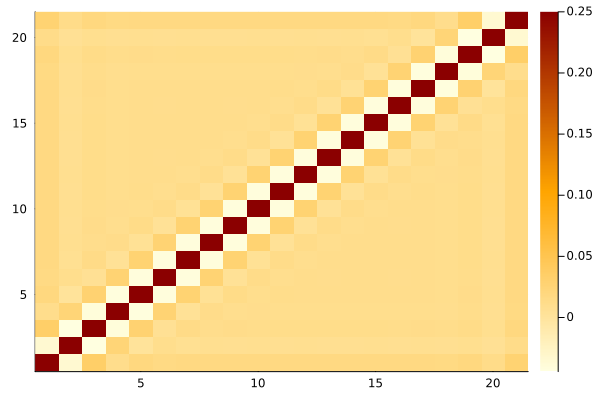

In [6]:
zzcorr = correlation_matrix(ψ_gs,"Sz","Sz");
gr()
heatmap(1:N, 1:N, zzcorr, c = :heat)

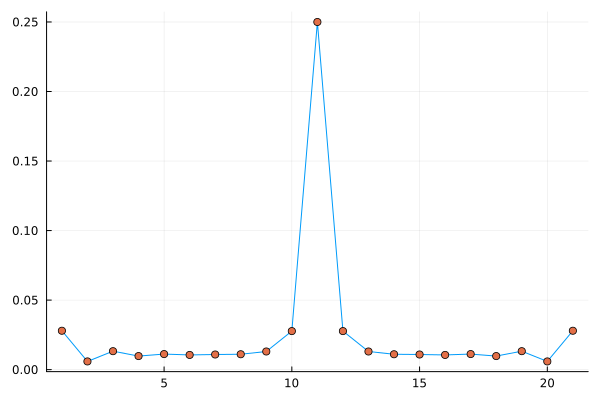

In [7]:
zzcen = diag(reverse(zzcorr, dims = 2));
plot(1:N, zzcen, label=false)  
scatter!(1:N, zzcen, label=false) 

## Extended system + ancilla

In [8]:
sitesext = siteinds("S=1/2",2*N); # Make 2N S=1/2 spin indices defining system + ancilla

In [9]:
# Extract the raising, lowering and identity operators for the extended system:

Sp = ops(sitesext, [("S+", n) for n in 1:(2*N)]);  # Raising operators
Sm = ops(sitesext, [("S-", n) for n in 1:(2*N)]);  # Lowering operators
# ITensors doesn't include the identity operator as standard so construct it:
Id = Vector{ITensor}(undef,2*N)
for i =1:(2*N)
    iv = sitesext[i]
    ID = ITensor(iv', dag(iv));
    for j in 1:ITensors.dim(iv)
        ID[iv' => j, iv => j] = 1.0
    end
    Id[i] = ID
end

In [10]:
# Construct the identity vacuum state:

Ivac = MPS(sitesext, "Up") # All up spins initial state
gates = [(Id[n]*Id[n+1] + Sm[n]*Sm[n+1]) for n in 1:2:(2*N)]; # Maps |00> => |00> + |11>
Ivac = apply(gates, Ivac; cutoff=1e-15); # Note we have no 1/sqrt(2) normalisation

In [11]:
# Vectorisation approach used here is to stack matrix rows into a column vector.
# This means that:
# vec(AB) = A ⊗ I vec(B) =  I ⊗ B^T vec(A)
# so |i><j| => |i> ⊗ |j>
# vec(L A R) = L ⊗ R^T vec(A)

# Define "Commutator" Hamiltonian operator terms:

# HC = H ⊗ I - I ⊗ H, since H is real and hermitian H = H^T

H_op = OpSum()
for i=1:2*(N-1)
    H_op += (-1)^(i-1) * J,"Sz",i,"Sz",i+2
end
for i=1:2*N
    H_op += (-1)^(i-1) * hx,"Sx",i
    H_op += (-1)^(i-1) * hz,"Sz",i
end
# Convert these terms to an MPO
HC = MPO(H_op,sitesext);

In [12]:
# Define observable for scrambling:
A_op = OpSum()
A_op += 1.0,"Sx",2*floor(Int,N/2+1)-1  # Sx operator in the middle of the system
A = MPO(A_op,sitesext);                # Build the MPO from these terms
Avec = apply(A, Ivac; cutoff=1e-15);   # Compute |A> = A|I>


function local_op(N,sitesex;r) #function used to define local operator to track C(r,t)
    site_index= 2*floor(Int,N/2+1)+r #defining site index
    Sx_r_system= op("Sx", sitesext, site_index)
    Sx_r_ancilla= op("Sx", sitesext, site_index+1)
    
    return Sx_r_system, Sx_r_ancilla
end;
# function local_op(N, sitesext, r)
#     site_index = 2 * floor(Int, N / 2 + 1) + r
#     Sx_r_system = op("Sx", sitesext, site_index)
#     Sx_r_ancilla = op("Sx", sitesext, site_index + 1)
    
#     return (Sx_r_system=Sx_r_system, Sx_r_ancilla=Sx_r_ancilla)
# end



local_op (generic function with 1 method)

## Perform TDVP time evolution of the operator

In [13]:
# Define function for computing entanglement entropy

function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    psi = ψ
    for b=1:N
        psi = orthogonalize(psi, b)
        if b==1
            U,S,V = svd(psi[b] , siteind(psi, b))
        else
            U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
        end
        p = diag(S).^2               # Extract square of Schmidt coefficients
        p = p ./ sum(p)              # Normalise to a probability dist
        SvN[b] = -sum(p .* log2.(p)) # Compute Shannon entropy
    end
    return SvN
end;

# Define function that calulates the commutator 
function compute_commutator(ψ,Sx_r_system,Sx_r_ancilla)
    Sx_a= apply(Sx_r_system,ψ;cutoff=1e-15)
    a_Sx= apply(Sx_r_ancilla,ψ;cutoff=1e-15)

    return Sx_a - a_Sx
end;

In [14]:
SvN_init = entanglement_entropy(Avec);
#plot(1:(2*N), SvN_init, label=false) 

Sx_5_system, Sx_5_ancilla= local_op(N,sitesext;r=5)
Sx_10_system, Sx_10_ancilla= local_op(N,sitesext;r=10)
init_commutator_5= compute_commutator(Avec,Sx_5_system,Sx_5_ancilla)
init_commutator_10= compute_commutator(Avec,Sx_10_system,Sx_10_ancilla);

Here $|A>$ displays the entanglement structure of the initial vacuum state.

In [15]:
# Define observer functions for TDVP:

function current_time(; current_time, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return real(-im*current_time)
  end
    
  return nothing
end

function measure_SvN(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return entanglement_entropy(psi)-SvN_init
  end
  return nothing
end;

function measure_linkdim(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return maxlinkdim(psi)
  end
  return nothing
end;

# function measure_commutator(;psi,bond,half_sweep,Sx_r_system=Sx_5_system,Sx_r_ancilla=Sx_5_ancilla)
#   if bond == 1 && half_sweep == 2
#     return compute_commutator(psi,Sx_r_system,Sx_r_ancilla) 
#   end
#   return nothing
# end;
function measure_commutator(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return [compute_commutator(psi, Sx_5_system, Sx_5_ancilla), compute_commutator(psi, Sx_10_system, Sx_10_ancilla)]
  end
  return nothing
end;





In [16]:
# Perform TDVP evolution of |A(t)>:

obs = Observer("times" => current_time, "SvN" => measure_SvN, "chi" => measure_linkdim,"Commutator"=>measure_commutator)



# d|A(t)>/dt = i HC |A(t)> so |A(t)> = exp(i t HC)|A(0)> 
ψf = tdvp(HC, im * T, Avec; 
          time_step = im * δt,
          normalize = false,
          maxdim = χ,
          cutoff = 1e-10,
          outputlevel=1,
          (observer!)=obs)

# Extract results from time-step observations
times=obs.times
SvN=obs.SvN
chi=obs.chi
Commutator=obs.Commutator;

After sweep 1: maxlinkdim=2 maxerr=2.52E-11

 current_time=0.0 + 0.05im time=36.285


After sweep 2: maxlinkdim=3 maxerr=9.45E-12 current_time=0.0 + 0.1im time=0.417


After sweep 3: maxlinkdim=3 maxerr=7.57E-11 current_time=0.0 + 0.15im time=0.291


After sweep 4: maxlinkdim=4 maxerr=8.70E-11 current_time=0.0 + 0.2im time=0.284


After sweep 5: maxlinkdim=6 maxerr=6.80E-14 current_time=0.0 + 0.25im time=0.298


After sweep 6: maxlinkdim=6 maxerr=9.75E-14 current_time=0.0 + 0.3im time=0.312


After sweep 7: maxlinkdim=6 maxerr=2.33E-13 current_time=0.0 + 0.35im time=0.304


After sweep 8: maxlinkdim=6 maxerr=9.56E-13 current_time=0.0 + 0.4im time=0.326


After sweep 9: maxlinkdim=6 maxerr=3.23E-12 current_time=0.0 + 0.45im time=0.317


After sweep 10: maxlinkdim=6 maxerr=9.09E-12 current_time=0.0 + 0.5im time=0.311


After sweep 11: maxlinkdim=6 maxerr=2.23E-11 current_time=0.0 + 0.55im time=0.329


After sweep 12: maxlinkdim=6 maxerr=4.92E-11 current_time=0.0 + 0.6im time=0.307


After sweep 13: maxlinkdim=6 maxerr=9.06E-11 current_time=0.0 + 0.65im time=0.309


After sweep 14: maxlinkdim=6 maxerr=9.82E-11 current_time=0.0 + 0.7im time=0.317


After sweep 15: maxlinkdim=6 maxerr=8.69E-11 current_time=0.0 + 0.75im time=0.328


After sweep 16: maxlinkdim=8 maxerr=1.86E-11 current_time=0.0 + 0.8im time=0.328


After sweep 17: maxlinkdim=8 maxerr=3.57E-11 current_time=0.0 + 0.85im time=0.318


After sweep 18: maxlinkdim=8 maxerr=6.62E-11 current_time=0.0 + 0.9im time=0.32


After sweep 19: maxlinkdim=8 maxerr=4.43E-11 current_time=0.0 + 0.95im time=0.322


After sweep 20: maxlinkdim=8 maxerr=8.37E-11 current_time=0.0 + 1.0im time=0.315


After sweep 21: maxlinkdim=8 maxerr=6.59E-11 current_time=0.0 + 1.05im time=0.327


After sweep 22: maxlinkdim=8 maxerr=7.76E-11 current_time=0.0 + 1.1im time=0.33


After sweep 23: maxlinkdim=8 maxerr=7.65E-11 current_time=0.0 + 1.15im time=0.353


After sweep 24: maxlinkdim=8 maxerr=6.16E-11 current_time=0.0 + 1.2im time=0.369


After sweep 25: maxlinkdim=8 maxerr=5.36E-11 current_time=0.0 + 1.25im time=0.36


After sweep 26: maxlinkdim=8 maxerr=9.44E-11 current_time=0.0 + 1.3im time=0.372


After sweep 27: maxlinkdim=8 maxerr=3.51E-11 current_time=0.0 + 1.35im time=0.357


After sweep 28: maxlinkdim=8 maxerr=5.43E-11 current_time=0.0 + 1.4im time=0.388


After sweep 29: maxlinkdim=8 maxerr=8.23E-11 current_time=0.0 + 1.45im time=0.363


After sweep 30: maxlinkdim=8 maxerr=2.74E-11 current_time=0.0 + 1.5im time=0.384


After sweep 31: maxlinkdim=8 maxerr=5.31E-11 current_time=0.0 + 1.55im time=0.367


After sweep 32: maxlinkdim=8 maxerr=9.64E-11 current_time=0.0 + 1.6im time=0.369


After sweep 33: maxlinkdim=8 maxerr=9.23E-11 current_time=0.0 + 1.65im time=0.388


After sweep 34: maxlinkdim=8 maxerr=7.35E-11 current_time=0.0 + 1.7im time=0.375


After sweep 35: maxlinkdim=8 maxerr=9.87E-11 current_time=0.0 + 1.75im time=0.386


After sweep 36: maxlinkdim=8 maxerr=6.17E-11 current_time=0.0 + 1.8im time=0.389


After sweep 37: maxlinkdim=8 maxerr=9.58E-11 current_time=0.0 + 1.85im time=0.399


After sweep 38: maxlinkdim=8 maxerr=9.64E-11 current_time=0.0 + 1.9im time=0.387


After sweep 39: maxlinkdim=9 maxerr=7.60E-11 current_time=0.0 + 1.95im time=0.404


After sweep 40: maxlinkdim=10 maxerr=5.19E-11 current_time=0.0 + 2.0im time=0.394


After sweep 41: maxlinkdim=10 maxerr=7.84E-11 current_time=0.0 + 2.05im time=0.429


After sweep 42: maxlinkdim=10 maxerr=9.41E-11 current_time=0.0 + 2.1im time=0.401


After sweep 43: maxlinkdim=11 maxerr=8.08E-11 current_time=0.0 + 2.15im time=0.403


After sweep 44: maxlinkdim=12 maxerr=7.79E-11 current_time=0.0 + 2.2im time=0.407


After sweep 45: maxlinkdim=12 maxerr=9.37E-11 current_time=0.0 + 2.25im time=0.411


After sweep 46: maxlinkdim=12 maxerr=8.47E-11 current_time=0.0 + 2.3im time=0.422


After sweep 47: maxlinkdim=12 maxerr=9.93E-11 current_time=0.0 + 2.35im time=0.409


After sweep 48: maxlinkdim=13 maxerr=8.33E-11 current_time=0.0 + 2.4im time=0.442


After sweep 49: maxlinkdim=14 maxerr=2.88E-11 current_time=0.0 + 2.45im time=0.459


After sweep 50: maxlinkdim=14 maxerr=4.63E-11 current_time=0.0 + 2.5im time=0.458


After sweep 51: maxlinkdim=14 maxerr=7.29E-11 current_time=0.0 + 2.55im time=0.457


After sweep 52: maxlinkdim=15 maxerr=8.90E-11 current_time=0.0 + 2.6im time=0.466


After sweep 53: maxlinkdim=15 maxerr=4.35E-11 current_time=0.0 + 2.65im time=0.477


After sweep 54: maxlinkdim=15 maxerr=6.34E-11 current_time=0.0 + 2.7im time=0.491


After sweep 55: maxlinkdim=15 maxerr=9.14E-11 current_time=0.0 + 2.75im time=0.478


After sweep 56: maxlinkdim=16 maxerr=7.39E-11 current_time=0.0 + 2.8im time=0.474


After sweep 57: maxlinkdim=16 maxerr=7.50E-11 current_time=0.0 + 2.85im time=0.507


After sweep 58: maxlinkdim=16 maxerr=8.52E-11 current_time=0.0 + 2.9im time=0.525


After sweep 59: maxlinkdim=16 maxerr=9.62E-11 current_time=0.0 + 2.95im time=0.505


After sweep 60: maxlinkdim=16 maxerr=8.02E-11 current_time=0.0 + 3.0im time=0.508


After sweep 61: maxlinkdim=17 maxerr=8.69E-11 current_time=0.0 + 3.05im time=0.518


After sweep 62: maxlinkdim=17 maxerr=8.66E-11 current_time=0.0 + 3.1im time=0.537


After sweep 63: maxlinkdim=18 maxerr=8.95E-11 current_time=0.0 + 3.15im time=0.576


After sweep 64: maxlinkdim=19 maxerr=7.37E-11 current_time=0.0 + 3.2im time=0.571


After sweep 65: maxlinkdim=19 maxerr=8.85E-11 current_time=0.0 + 3.25im time=0.579


After sweep 66: maxlinkdim=20 maxerr=9.91E-11 current_time=0.0 + 3.3im time=0.613


After sweep 67: maxlinkdim=20 maxerr=8.77E-11 current_time=0.0 + 3.35im time=0.602


After sweep 68: maxlinkdim=21 maxerr=7.59E-11 current_time=0.0 + 3.4im time=0.648


After sweep 69: maxlinkdim=21 maxerr=8.85E-11 current_time=0.0 + 3.45im time=0.647


After sweep 70: maxlinkdim=22 maxerr=8.64E-11 current_time=0.0 + 3.5im time=0.657


After sweep 71: maxlinkdim=22 maxerr=6.51E-11 current_time=0.0 + 3.55im time=0.649


After sweep 72: maxlinkdim=22 maxerr=9.03E-11 current_time=0.0 + 3.6im time=0.683


After sweep 73: maxlinkdim=23 maxerr=9.54E-11 current_time=0.0 + 3.65im time=0.829


After sweep 74: maxlinkdim=23 maxerr=8.91E-11 current_time=0.0 + 3.7im time=0.811


After sweep 75: maxlinkdim=24 maxerr=6.84E-11 current_time=0.0 + 3.75im time=0.873


After sweep 76: maxlinkdim=24 maxerr=8.96E-11 current_time=0.0 + 3.8im time=0.933


After sweep 77: maxlinkdim=25 maxerr=9.91E-11 current_time=0.0 + 3.85im time=0.943


After sweep 78: maxlinkdim=25 maxerr=7.97E-11 current_time=0.0 + 3.9im time=0.949


After sweep 79: maxlinkdim=26 maxerr=9.69E-11 current_time=0.0 + 3.95im time=0.946


After sweep 80: maxlinkdim=26 maxerr=9.34E-11 current_time=0.0 + 4.0im time=0.945


After sweep 81: maxlinkdim=26 maxerr=7.88E-11 current_time=0.0 + 4.05im time=1.056


After sweep 82: maxlinkdim=27 maxerr=9.06E-11 current_time=0.0 + 4.1im time=1.211


After sweep 83: maxlinkdim=27 maxerr=8.05E-11 current_time=0.0 + 4.15im time=0.889


After sweep 84: maxlinkdim=27 maxerr=9.66E-11 current_time=0.0 + 4.2im time=0.879


After sweep 85: maxlinkdim=27 maxerr=9.76E-11 current_time=0.0 + 4.25im time=0.879


After sweep 86: maxlinkdim=28 maxerr=9.96E-11 current_time=0.0 + 4.3im time=0.918


After sweep 87: maxlinkdim=29 maxerr=7.81E-11 current_time=0.0 + 4.35im time=0.903


After sweep 88: maxlinkdim=29 maxerr=9.97E-11 current_time=0.0 + 4.4im time=0.946


After sweep 89: maxlinkdim=30 maxerr=9.32E-11 current_time=0.0 + 4.45im time=0.937


After sweep 90: maxlinkdim=30 maxerr=9.56E-11 current_time=0.0 + 4.5im time=0.971


After sweep 91: maxlinkdim=31 maxerr=9.44E-11 current_time=0.0 + 4.55im time=1.008


After sweep 92: maxlinkdim=31 maxerr=9.58E-11 current_time=0.0 + 4.6im time=1.05


After sweep 93: maxlinkdim=32 maxerr=9.75E-11 current_time=0.0 + 4.65im time=1.132


After sweep 94: maxlinkdim=32 maxerr=9.82E-11 current_time=0.0 + 4.7im time=1.068


After sweep 95: maxlinkdim=32 maxerr=1.31E-10 current_time=0.0 + 4.75im time=1.082


After sweep 96: maxlinkdim=32 maxerr=1.74E-10 current_time=0.0 + 4.8im time=1.077


After sweep 97: maxlinkdim=32 maxerr=2.29E-10 current_time=0.0 + 4.85im time=1.178


After sweep 98: maxlinkdim=32 maxerr=2.98E-10 current_time=0.0 + 4.9im time=1.131


After sweep 99: maxlinkdim=32 maxerr=3.85E-10 current_time=0.0 + 4.95im time=1.158


After sweep 100: maxlinkdim=32 maxerr=4.95E-10 current_time=0.0 + 5.0im time=1.198


After sweep 101: maxlinkdim=32 maxerr=6.31E-10 current_time=0.0 + 5.05im time=1.217


After sweep 102: maxlinkdim=32 maxerr=8.02E-10 current_time=0.0 + 5.1im time=1.236


After sweep 103: maxlinkdim=32 maxerr=1.02E-09 current_time=0.0 + 5.15im time=1.184


After sweep 104: maxlinkdim=32 maxerr=1.29E-09 current_time=0.0 + 5.2im time=1.265


After sweep 105: maxlinkdim=32 maxerr=1.63E-09 current_time=0.0 + 5.25im time=1.257


After sweep 106: maxlinkdim=32 maxerr=2.06E-09 current_time=0.0 + 5.3im time=1.281


After sweep 107: maxlinkdim=32 maxerr=2.62E-09 current_time=0.0 + 5.35im time=1.246


After sweep 108: maxlinkdim=32 maxerr=3.33E-09 current_time=0.0 + 5.4im time=1.253


After sweep 109: maxlinkdim=32 maxerr=4.23E-09 current_time=0.0 + 5.45im time=1.292


After sweep 110: maxlinkdim=32 maxerr=5.37E-09 current_time=0.0 + 5.5im time=1.356


After sweep 111: maxlinkdim=32 maxerr=6.80E-09 current_time=0.0 + 5.55im time=1.341


After sweep 112: maxlinkdim=32 maxerr=8.57E-09 current_time=0.0 + 5.6im time=1.34


After sweep 113: maxlinkdim=32 maxerr=1.07E-08 current_time=0.0 + 5.65im time=1.355


After sweep 114: maxlinkdim=32 maxerr=1.33E-08 current_time=0.0 + 5.7im time=1.43


After sweep 115: maxlinkdim=32 maxerr=1.64E-08 current_time=0.0 + 5.75im time=1.366


After sweep 116: maxlinkdim=32 maxerr=2.00E-08 current_time=0.0 + 5.8im time=1.404


After sweep 117: maxlinkdim=32 maxerr=2.41E-08 current_time=0.0 + 5.85im time=1.436


After sweep 118: maxlinkdim=32 maxerr=2.88E-08 current_time=0.0 + 5.9im time=1.442


After sweep 119: maxlinkdim=32 maxerr=3.40E-08 current_time=0.0 + 5.95im time=1.45


After sweep 120: maxlinkdim=32 maxerr=3.98E-08 current_time=0.0 + 6.0im time=1.454


After sweep 121: maxlinkdim=32 maxerr=4.61E-08 current_time=0.0 + 6.05im time=1.516


After sweep 122: maxlinkdim=32 maxerr=5.29E-08 current_time=0.0 + 6.1im time=1.485


After sweep 123: maxlinkdim=32 maxerr=6.03E-08 current_time=0.0 + 6.15im time=1.562


After sweep 124: maxlinkdim=32 maxerr=6.81E-08 current_time=0.0 + 6.2im time=1.586


After sweep 125: maxlinkdim=32 maxerr=7.64E-08 current_time=0.0 + 6.25im time=1.504


After sweep 126: maxlinkdim=32 maxerr=8.52E-08 current_time=0.0 + 6.3im time=1.533


After sweep 127: maxlinkdim=32 maxerr=9.45E-08 current_time=0.0 + 6.35im time=1.592


After sweep 128: maxlinkdim=32 maxerr=1.04E-07 current_time=0.0 + 6.4im time=1.657


After sweep 129: maxlinkdim=32 maxerr=1.15E-07 current_time=0.0 + 6.45im time=1.612


After sweep 130: maxlinkdim=32 maxerr=1.26E-07 current_time=0.0 + 6.5im time=1.744


After sweep 131: maxlinkdim=32 maxerr=1.38E-07 current_time=0.0 + 6.55im time=1.633


After sweep 132: maxlinkdim=32 maxerr=1.51E-07 current_time=0.0 + 6.6im time=1.621


After sweep 133: maxlinkdim=32 maxerr=1.66E-07 current_time=0.0 + 6.65im time=1.591


After sweep 134: maxlinkdim=32 maxerr=1.82E-07 current_time=0.0 + 6.7im time=1.702


After sweep 135: maxlinkdim=32 maxerr=2.00E-07 current_time=0.0 + 6.75im time=1.631


After sweep 136: maxlinkdim=32 maxerr=2.19E-07 current_time=0.0 + 6.8im time=1.672


After sweep 137: maxlinkdim=32 maxerr=2.41E-07 current_time=0.0 + 6.85im time=1.757


After sweep 138: maxlinkdim=32 maxerr=2.65E-07 current_time=0.0 + 6.9im time=1.679


After sweep 139: maxlinkdim=32 maxerr=2.91E-07 current_time=0.0 + 6.95im time=1.73


After sweep 140: maxlinkdim=32 maxerr=3.19E-07 current_time=0.0 + 7.0im time=1.757


After sweep 141: maxlinkdim=32 maxerr=3.49E-07 current_time=0.0 + 7.05im time=1.784


After sweep 142: maxlinkdim=32 maxerr=3.82E-07 current_time=0.0 + 7.1im time=1.751


After sweep 143: maxlinkdim=32 maxerr=4.17E-07 current_time=0.0 + 7.15im time=1.826


After sweep 144: maxlinkdim=32 maxerr=4.55E-07 current_time=0.0 + 7.2im time=1.788


After sweep 145: maxlinkdim=32 maxerr=4.95E-07 current_time=0.0 + 7.25im time=1.783


After sweep 146: maxlinkdim=32 maxerr=5.36E-07 current_time=0.0 + 7.3im time=1.899


After sweep 147: maxlinkdim=32 maxerr=5.80E-07 current_time=0.0 + 7.35im time=1.86


After sweep 148: maxlinkdim=32 maxerr=6.26E-07 current_time=0.0 + 7.4im time=1.883


After sweep 149: maxlinkdim=32 maxerr=6.72E-07 current_time=0.0 + 7.45im time=1.92


After sweep 150: maxlinkdim=32 maxerr=7.20E-07 current_time=0.0 + 7.5im time=1.931


After sweep 151: maxlinkdim=32 maxerr=7.69E-07 current_time=0.0 + 7.55im time=2.0


After sweep 152: maxlinkdim=32 maxerr=8.19E-07 current_time=0.0 + 7.6im time=1.917


After sweep 153: maxlinkdim=32 maxerr=8.68E-07 current_time=0.0 + 7.65im time=1.954


After sweep 154: maxlinkdim=32 maxerr=9.16E-07 current_time=0.0 + 7.7im time=1.998


After sweep 155: maxlinkdim=32 maxerr=9.64E-07 current_time=0.0 + 7.75im time=2.11


After sweep 156: maxlinkdim=32 maxerr=1.01E-06 current_time=0.0 + 7.8im time=2.608


After sweep 157: maxlinkdim=32 maxerr=1.05E-06 current_time=0.0 + 7.85im time=2.18


After sweep 158: maxlinkdim=32 maxerr=1.10E-06 current_time=0.0 + 7.9im time=2.075


After sweep 159: maxlinkdim=32 maxerr=1.14E-06 current_time=0.0 + 7.95im time=2.046


After sweep 160: maxlinkdim=32 maxerr=1.18E-06 current_time=0.0 + 8.0im time=2.1


After sweep 161: maxlinkdim=32 maxerr=1.21E-06 current_time=0.0 + 8.05im time=2.116


After sweep 162: maxlinkdim=32 maxerr=1.24E-06 current_time=0.0 + 8.1im time=2.067


After sweep 163: maxlinkdim=32 maxerr=1.27E-06 current_time=0.0 + 8.15im time=2.05


After sweep 164: maxlinkdim=32 maxerr=1.30E-06 current_time=0.0 + 8.2im time=2.085


After sweep 165: maxlinkdim=32 maxerr=1.33E-06 current_time=0.0 + 8.25im time=2.085


After sweep 166: maxlinkdim=32 maxerr=1.35E-06 current_time=0.0 + 8.3im time=2.166


After sweep 167: maxlinkdim=32 maxerr=1.37E-06 current_time=0.0 + 8.35im time=2.132


After sweep 168: maxlinkdim=32 maxerr=1.39E-06 current_time=0.0 + 8.4im time=2.157


After sweep 169: maxlinkdim=32 maxerr=1.41E-06 current_time=0.0 + 8.45im time=2.138


After sweep 170: maxlinkdim=32 maxerr=1.43E-06 current_time=0.0 + 8.5im time=2.145


After sweep 171: maxlinkdim=32 maxerr=1.46E-06 current_time=0.0 + 8.55im time=2.284


After sweep 172: maxlinkdim=32 maxerr=1.48E-06 current_time=0.0 + 8.6im time=2.174


After sweep 173: maxlinkdim=32 maxerr=1.50E-06 current_time=0.0 + 8.65im time=2.27


After sweep 174: maxlinkdim=32 maxerr=1.55E-06 current_time=0.0 + 8.7im time=2.178


After sweep 175: maxlinkdim=32 maxerr=1.60E-06 current_time=0.0 + 8.75im time=2.269


After sweep 176: maxlinkdim=32 maxerr=1.65E-06 current_time=0.0 + 8.8im time=2.215


After sweep 177: maxlinkdim=32 maxerr=1.70E-06 current_time=0.0 + 8.85im time=2.239


After sweep 178: maxlinkdim=32 maxerr=1.75E-06 current_time=0.0 + 8.9im time=2.575


After sweep 179: maxlinkdim=32 maxerr=1.81E-06 current_time=0.0 + 8.95im time=2.313


After sweep 180: maxlinkdim=32 maxerr=1.86E-06 current_time=0.0 + 9.0im time=2.355


After sweep 181: maxlinkdim=32 maxerr=1.92E-06 current_time=0.0 + 9.05im time=2.309


After sweep 182: maxlinkdim=32 maxerr=1.98E-06 current_time=0.0 + 9.1im time=2.398


After sweep 183: maxlinkdim=32 maxerr=2.04E-06 current_time=0.0 + 9.15im time=2.414


After sweep 184: maxlinkdim=32 maxerr=2.11E-06 current_time=0.0 + 9.2im time=2.494


After sweep 185: maxlinkdim=32 maxerr=2.17E-06 current_time=0.0 + 9.25im time=2.433


After sweep 186: maxlinkdim=32 maxerr=2.24E-06 current_time=0.0 + 9.3im time=2.523


After sweep 187: maxlinkdim=32 maxerr=2.30E-06 current_time=0.0 + 9.35im time=2.487


After sweep 188: maxlinkdim=32 maxerr=2.37E-06 current_time=0.0 + 9.4im time=2.564


After sweep 189: maxlinkdim=32 maxerr=2.44E-06 current_time=0.0 + 9.45im time=2.464


After sweep 190: maxlinkdim=32 maxerr=2.51E-06 current_time=0.0 + 9.5im time=2.522


After sweep 191: maxlinkdim=32 maxerr=2.58E-06 current_time=0.0 + 9.55im time=2.726


After sweep 192: maxlinkdim=32 maxerr=2.64E-06 current_time=0.0 + 9.6im time=2.617


After sweep 193: maxlinkdim=32 maxerr=2.71E-06 current_time=0.0 + 9.65im time=2.558


After sweep 194: maxlinkdim=32 maxerr=2.78E-06 current_time=0.0 + 9.7im time=2.585


After sweep 195: maxlinkdim=32 maxerr=2.84E-06 current_time=0.0 + 9.75im time=2.559


After sweep 196: maxlinkdim=32 maxerr=2.91E-06 current_time=0.0 + 9.8im time=2.583


After sweep 197: maxlinkdim=32 maxerr=2.98E-06 current_time=0.0 + 9.85im time=2.558


After sweep 198: maxlinkdim=32 maxerr=3.04E-06 current_time=0.0 + 9.9im time=2.701


After sweep 199: maxlinkdim=32 maxerr=3.10E-06 current_time=0.0 + 9.95im time=2.628


After sweep 200: maxlinkdim=32 maxerr=3.16E-06 current_time=0.0 + 10.0im time=2.695


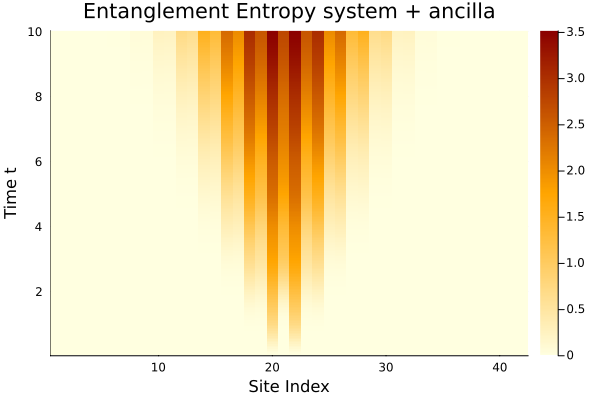

In [17]:
# Plot the entanglement entropy of each bond for system + ancilla:
gr()
heatmap(1:(2*N), times, reduce(vcat,transpose.(SvN)), c = :heat)
ylabel!("Time t")
xlabel!("Site Index")
title!("Entanglement Entropy system + ancilla")

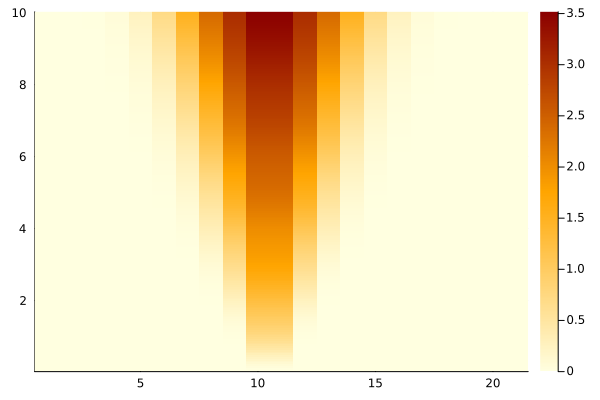

In [18]:
# Plot the entanglement entropy for bonds separating system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,2:2:(2*N)]
heatmap(1:N, times, S, c = :heat)

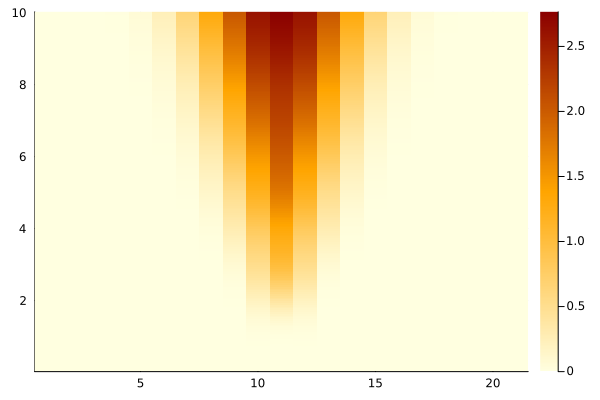

In [19]:
# Plot entanglement entropy of bonds between system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,1:2:(2*N)]
heatmap(1:N, times, S, c = :heat)

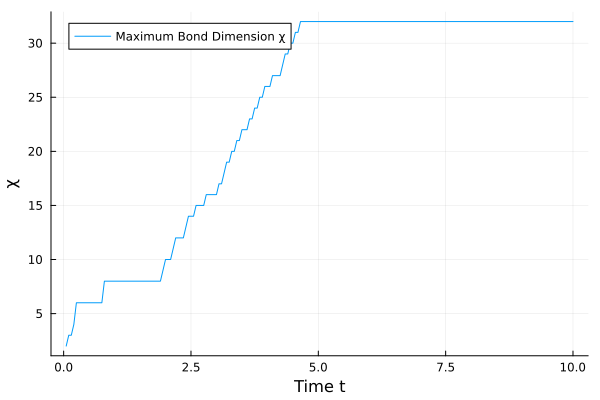

In [20]:
# Plot the growth in the maximum link dimension with time:
plot(times, chi, label="Maximum Bond Dimension χ",framstyle=:box,legend=:topleft)  
#scatter!(times, chi, label=false) 

xlabel!("Time t")
ylabel!("χ")

In [183]:
function calculate_inner_product(Commutator_array, N)
    inner_product_array_5 = []
    inner_product_array_10 = []

    for entry in Commutator_array
        
        inner_product_5 = inner(entry[1], entry[1])
        push!(inner_product_array_5, inner_product_5)

        inner_product_10 = inner(entry[2], entry[2])
        push!(inner_product_array_10, inner_product_10)
    end
    return inner_product_array_5, inner_product_array_10
end


Commutator_inner_product_5 ,Commutator_inner_product_10 = real.(calculate_inner_product(Commutator,N))
Commutator_inner_product_5 = real.(Commutator_inner_product_5)
Commutator_inner_product_10 = real.(Commutator_inner_product_10)

C_r_t_5= (1/(2^N))*Commutator_inner_product_5
C_r_t_10= (1/(2^N))*Commutator_inner_product_10

@show size(Commutator_inner_product_10);

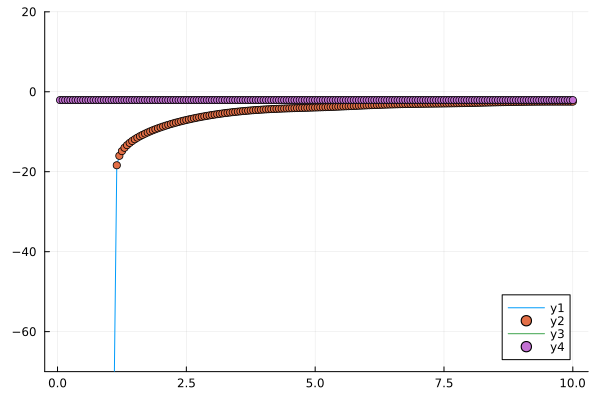

In [200]:
min_y = -70

plot(times,log.(C_r_t_5), ylim=(min_y, 20))
scatter!(times,log.(C_r_t_5), ylim=(min_y, 20))
plot!(times,log.(C_r_t_10), ylim=(min_y, 20))
scatter!(times,log.(C_r_t_10), ylim=(min_y, 20))
